# Solution - 1

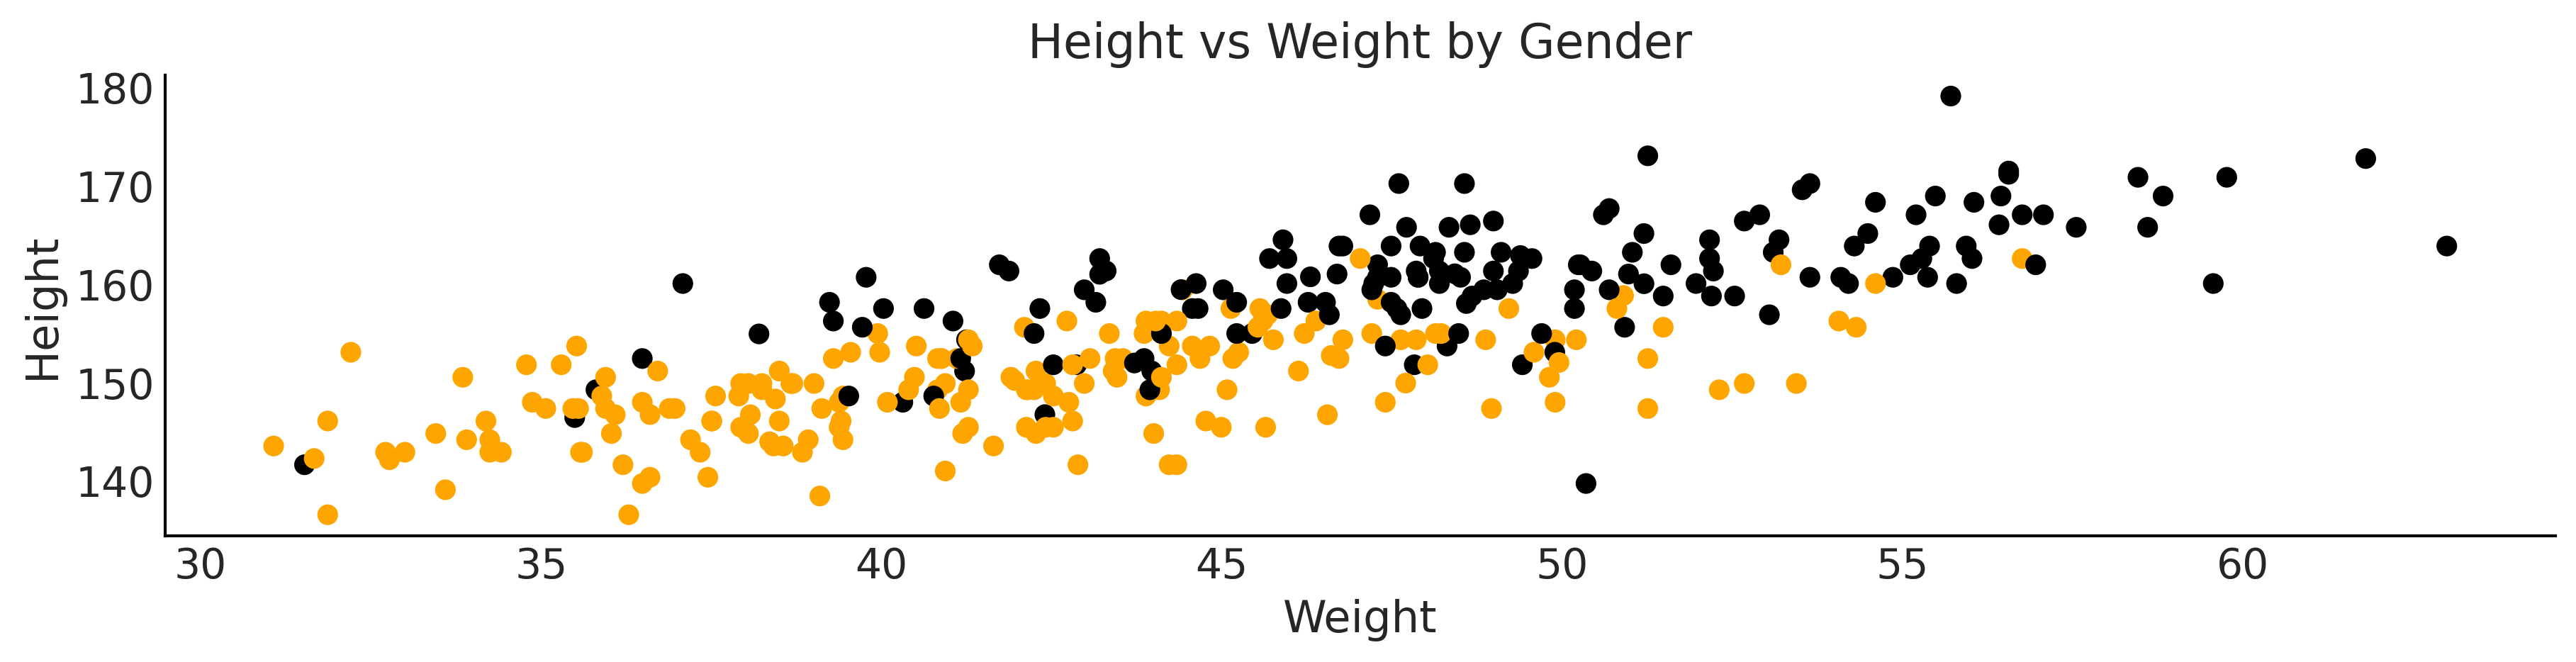

In [ ]:
# Upload data on Google Colab.

#from google.colab import files
#uloaded = files.upload()

#!pip install preliz

# Import all the required libraries.

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import xarray as xr
from scipy.interpolate import PchipInterpolator
from scipy.stats import linregress

az.style.use("arviz-grayscale")
from cycler import cycler

default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc("axes", prop_cycle=default_cycler)
plt.rc("figure", dpi=300)
np.random.seed(123)

# Import the dataset using Pandas.

df = pd.read_csv("howell.csv", delimiter=";")
#df.head()

adults = df[df['age'] >= 18]

# Plot the scatter plot

colors = adults['male'].map({1: 'black', 0: 'orange'})
plt.figure(figsize=(12, 3))
plt.scatter(adults['weight'], adults['height'], c=colors)
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Height vs Weight by Gender')
plt.show()

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

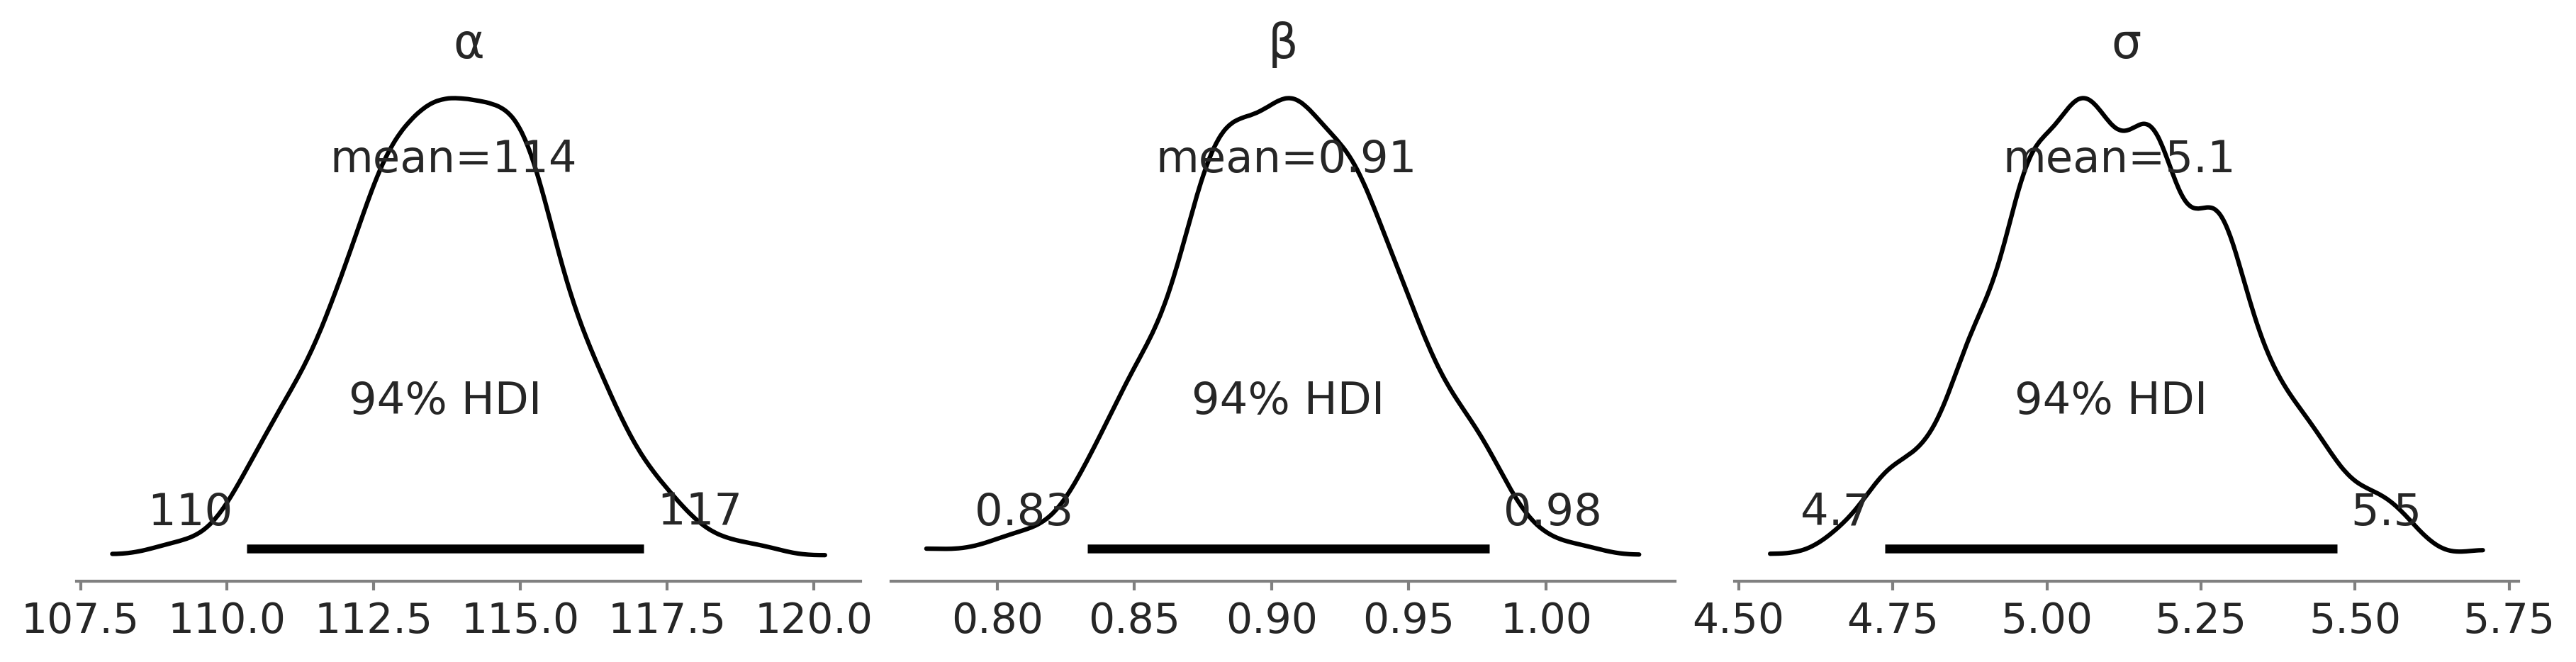

In [89]:
with pm.Model() as model_lb:
    weight = pm.Data("weight", adults.weight, mutable= True)
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)
    σ = pm.HalfCauchy("σ", 10)
    μ = pm.Deterministic("μ", α + β * weight)
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=adults.height)
    idata_lb = pm.sample(random_seed=123)

az.plot_posterior(idata_lb, var_names=["~μ"], figsize=(12, 3))

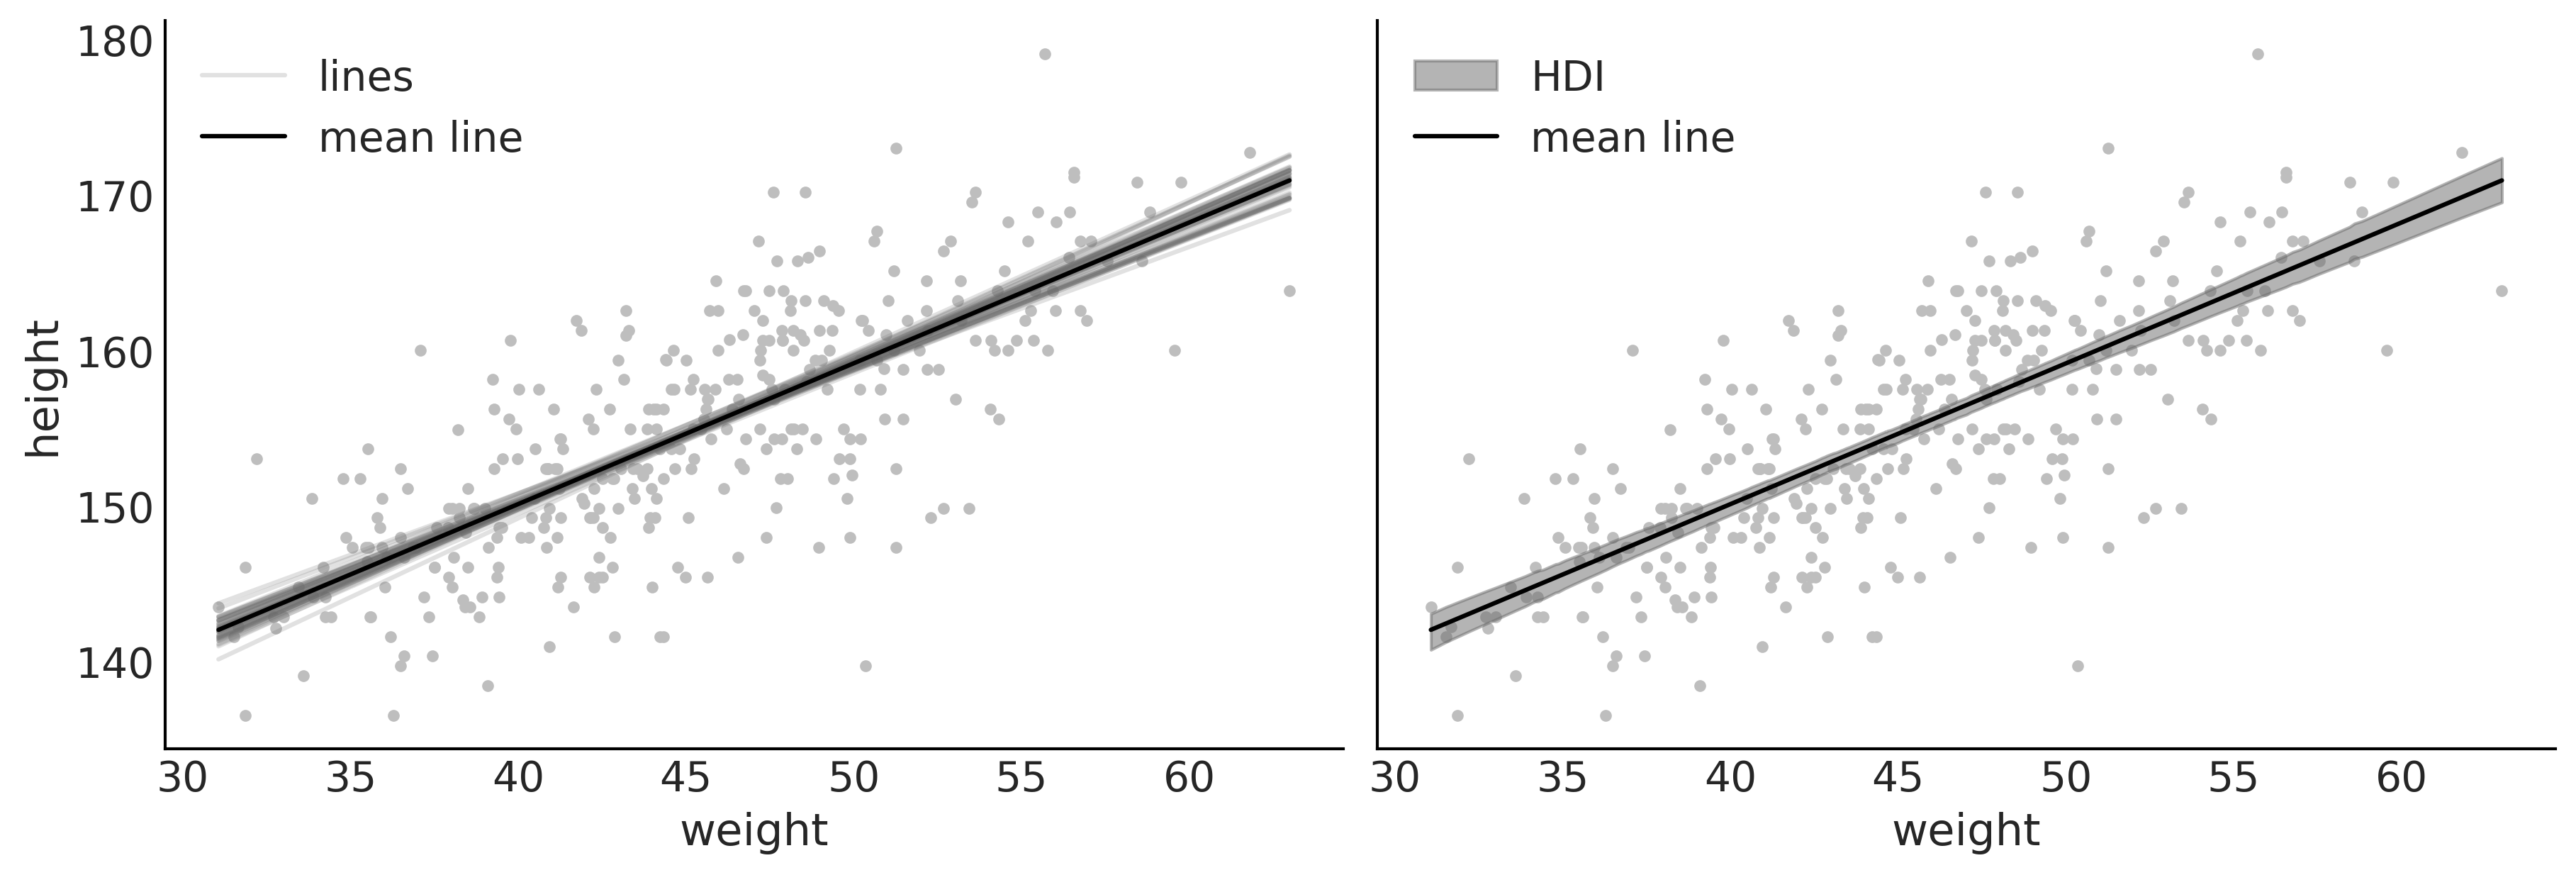

In [ ]:
posterior = az.extract(idata_lb, num_samples=50)
x_plot = xr.DataArray(
    np.linspace(adults.weight.min(), adults.weight.max(), 50), dims="plot_id"
)
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot
lines = posterior["α"] + posterior["β"] * x_plot
hdi_lines = az.hdi(idata_lb.posterior["μ"])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].plot(adults.weight, adults.height, "C2.", zorder=-3)
lines_ = axes[0].plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")
plt.setp(lines_[1:], label="_")
axes[0].plot(x_plot, mean_line, c="C0", label="mean line")
axes[0].set_xlabel("weight")
axes[0].set_ylabel("height")
axes[0].legend()

axes[1].plot(adults.weight, adults.height, "C2.", zorder=-3)
idx = np.argsort(adults.weight.values)
axes[1].fill_between(
    adults.weight.iloc[idx],
    hdi_lines["μ"][:, 0][idx],
    hdi_lines["μ"][:, 1][idx],
    color="C1",
    label="HDI",
    alpha=0.5,
)
axes[1].plot(x_plot, mean_line, c="C0", label="mean line")
axes[1].set_xlabel("weight")
axes[1].legend()
plt.show()

In [ ]:
# Results -

print(f'Mean Height Intercept is α : 114')
print(f'Mean Height Slope is β : 0.91')
print(f'This implies for weight let say 50, height is between [{110 + 0.83*50}, {117 + 0.98*50}]')

Mean Height Intercept is α : 114
Mean Height Slope is β : 0.91
This implies for weight let say 50, height is between [151.5, 166.0]


# Solution - 2

In [99]:
weights = [45.73, 65.8, 54.2, 32.59]

with model_lb:
  pm.set_data({'weight': weights})

for weight in weights:
  pred = []
  samples = az.extract(idata_lb, num_samples = 1000)
  α_samples = samples["α"]
  β_samples = samples["β"]
  for α, β in zip(α_samples, β_samples):
    pred.append(α + β * weight)
  pred = np.array(pred)
  print(f"Weight: {weight}")
  print(f"Mean Predicted Heights: {np.mean(pred):.2f}")
  hdi_50 = az.hdi(pred, hdi_prob=0.50)
  hdi_94 = az.hdi(pred, hdi_prob=0.94)
  print(f"50% HDI: [{hdi_50[0]:.2f}, {hdi_50[1]:.2f}]")
  print(f"94% HDI: [{hdi_94[0]:.2f}, {hdi_94[1]:.2f}]")
  print()

Weight: 45.73
Mean Predicted Heights: 155.27
50% HDI: [155.14, 155.50]
94% HDI: [154.74, 155.73]

Weight: 65.8
Mean Predicted Heights: 173.43
50% HDI: [172.89, 174.06]
94% HDI: [171.84, 175.08]

Weight: 54.2
Mean Predicted Heights: 162.94
50% HDI: [162.54, 163.18]
94% HDI: [162.07, 163.81]

Weight: 32.59
Mean Predicted Heights: 143.37
50% HDI: [143.09, 143.84]
94% HDI: [142.34, 144.48]



# Solution - 3

AIM : To analyze dependencies of position and number of shots taken on goals scored.



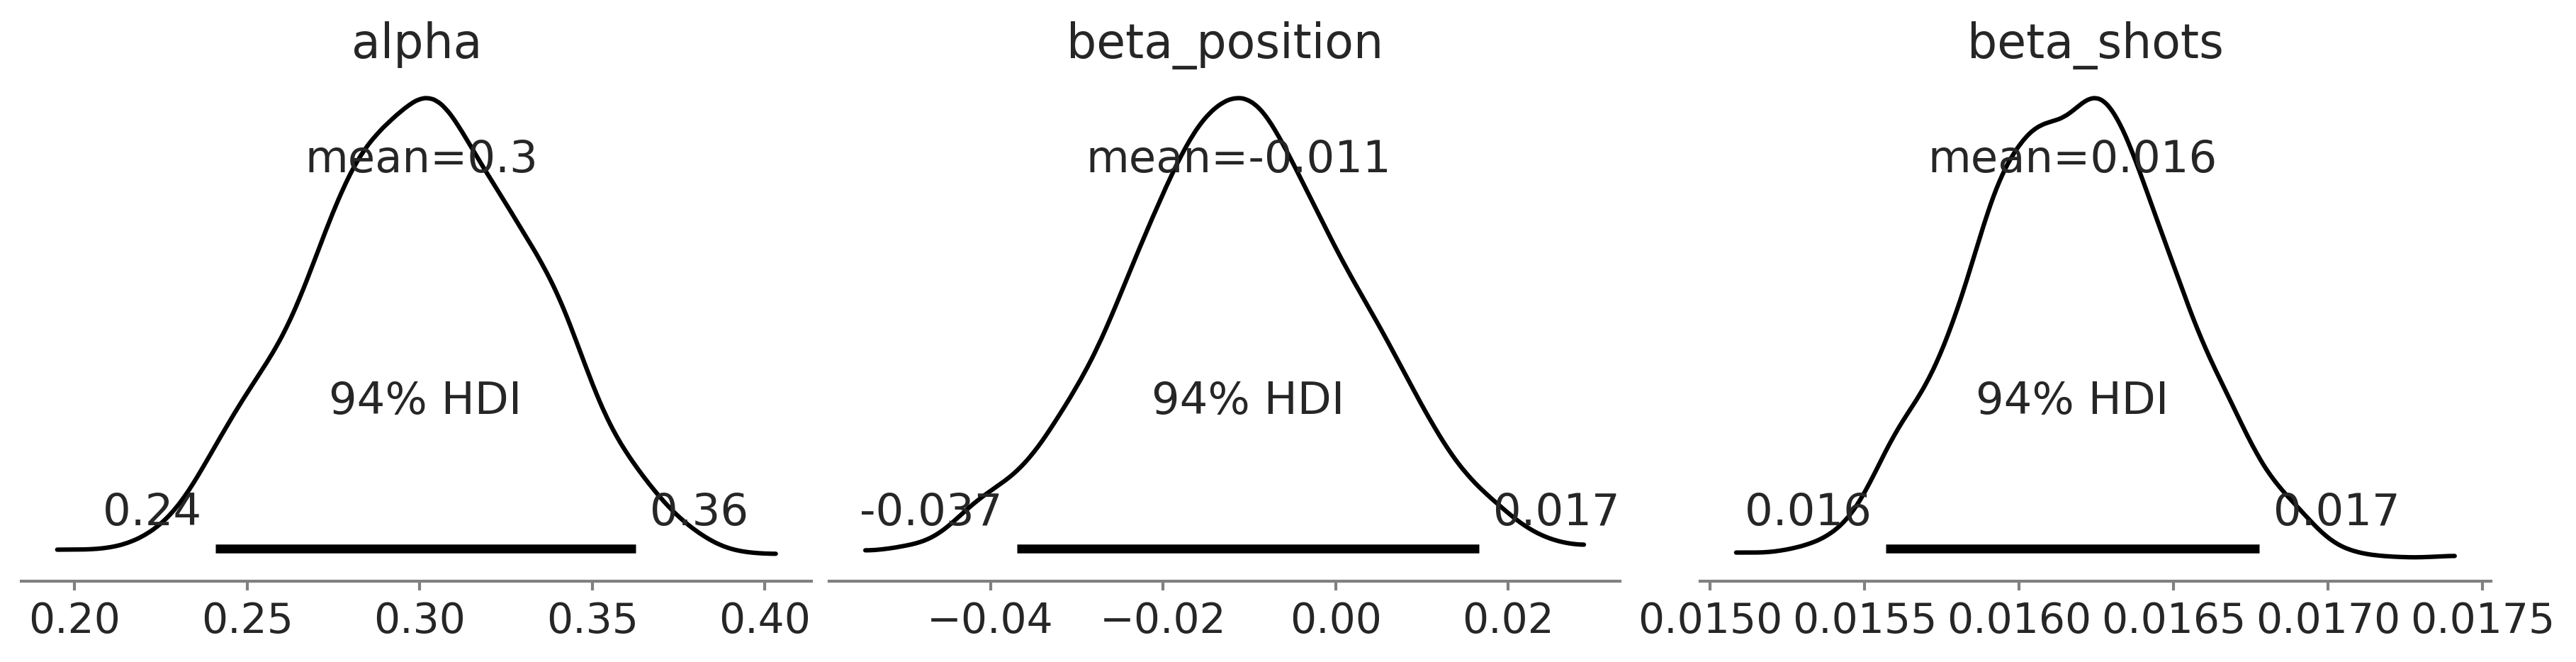

In [147]:
# from google.colab import files
# uploaded = files.upload()

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv("football_players.csv")
# df.head()

print("AIM : To analyze dependencies of position and number of shots taken on goals scored.\n")

label_encoder = LabelEncoder()
df['position_encoded'] = label_encoder.fit_transform(df['position'])
# df['position_encoded'] = df['position_encoded'].astype(float)

# print(df.head())

X = df[['position_encoded', 'shots']]
y = df['goals']

# Defining the model.
with pm.Model() as model:
    position_encoded = pm.MutableData("position_encoded", X['position_encoded'].values)
    shots = pm.MutableData("shots", X['shots'].values)

    alpha = pm.HalfNormal("alpha", sigma=1)
    beta_position = pm.Normal("beta_position", mu=0, sigma=10)
    beta_shots = pm.Normal("beta_shots", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = pm.Deterministic("mu", pm.math.exp(alpha + beta_position * position_encoded + beta_shots * shots))
    y_obs = pm.NegativeBinomial("y_obs", mu=mu, alpha=sigma, observed=y.values)
    trace = pm.sample(random_seed = 123)
    trace.extend(pm.sample_posterior_predictive(trace, random_seed=123))

az.plot_posterior(trace, var_names=["alpha", "beta_position", "beta_shots"], figsize=(12, 3))
plt.show()

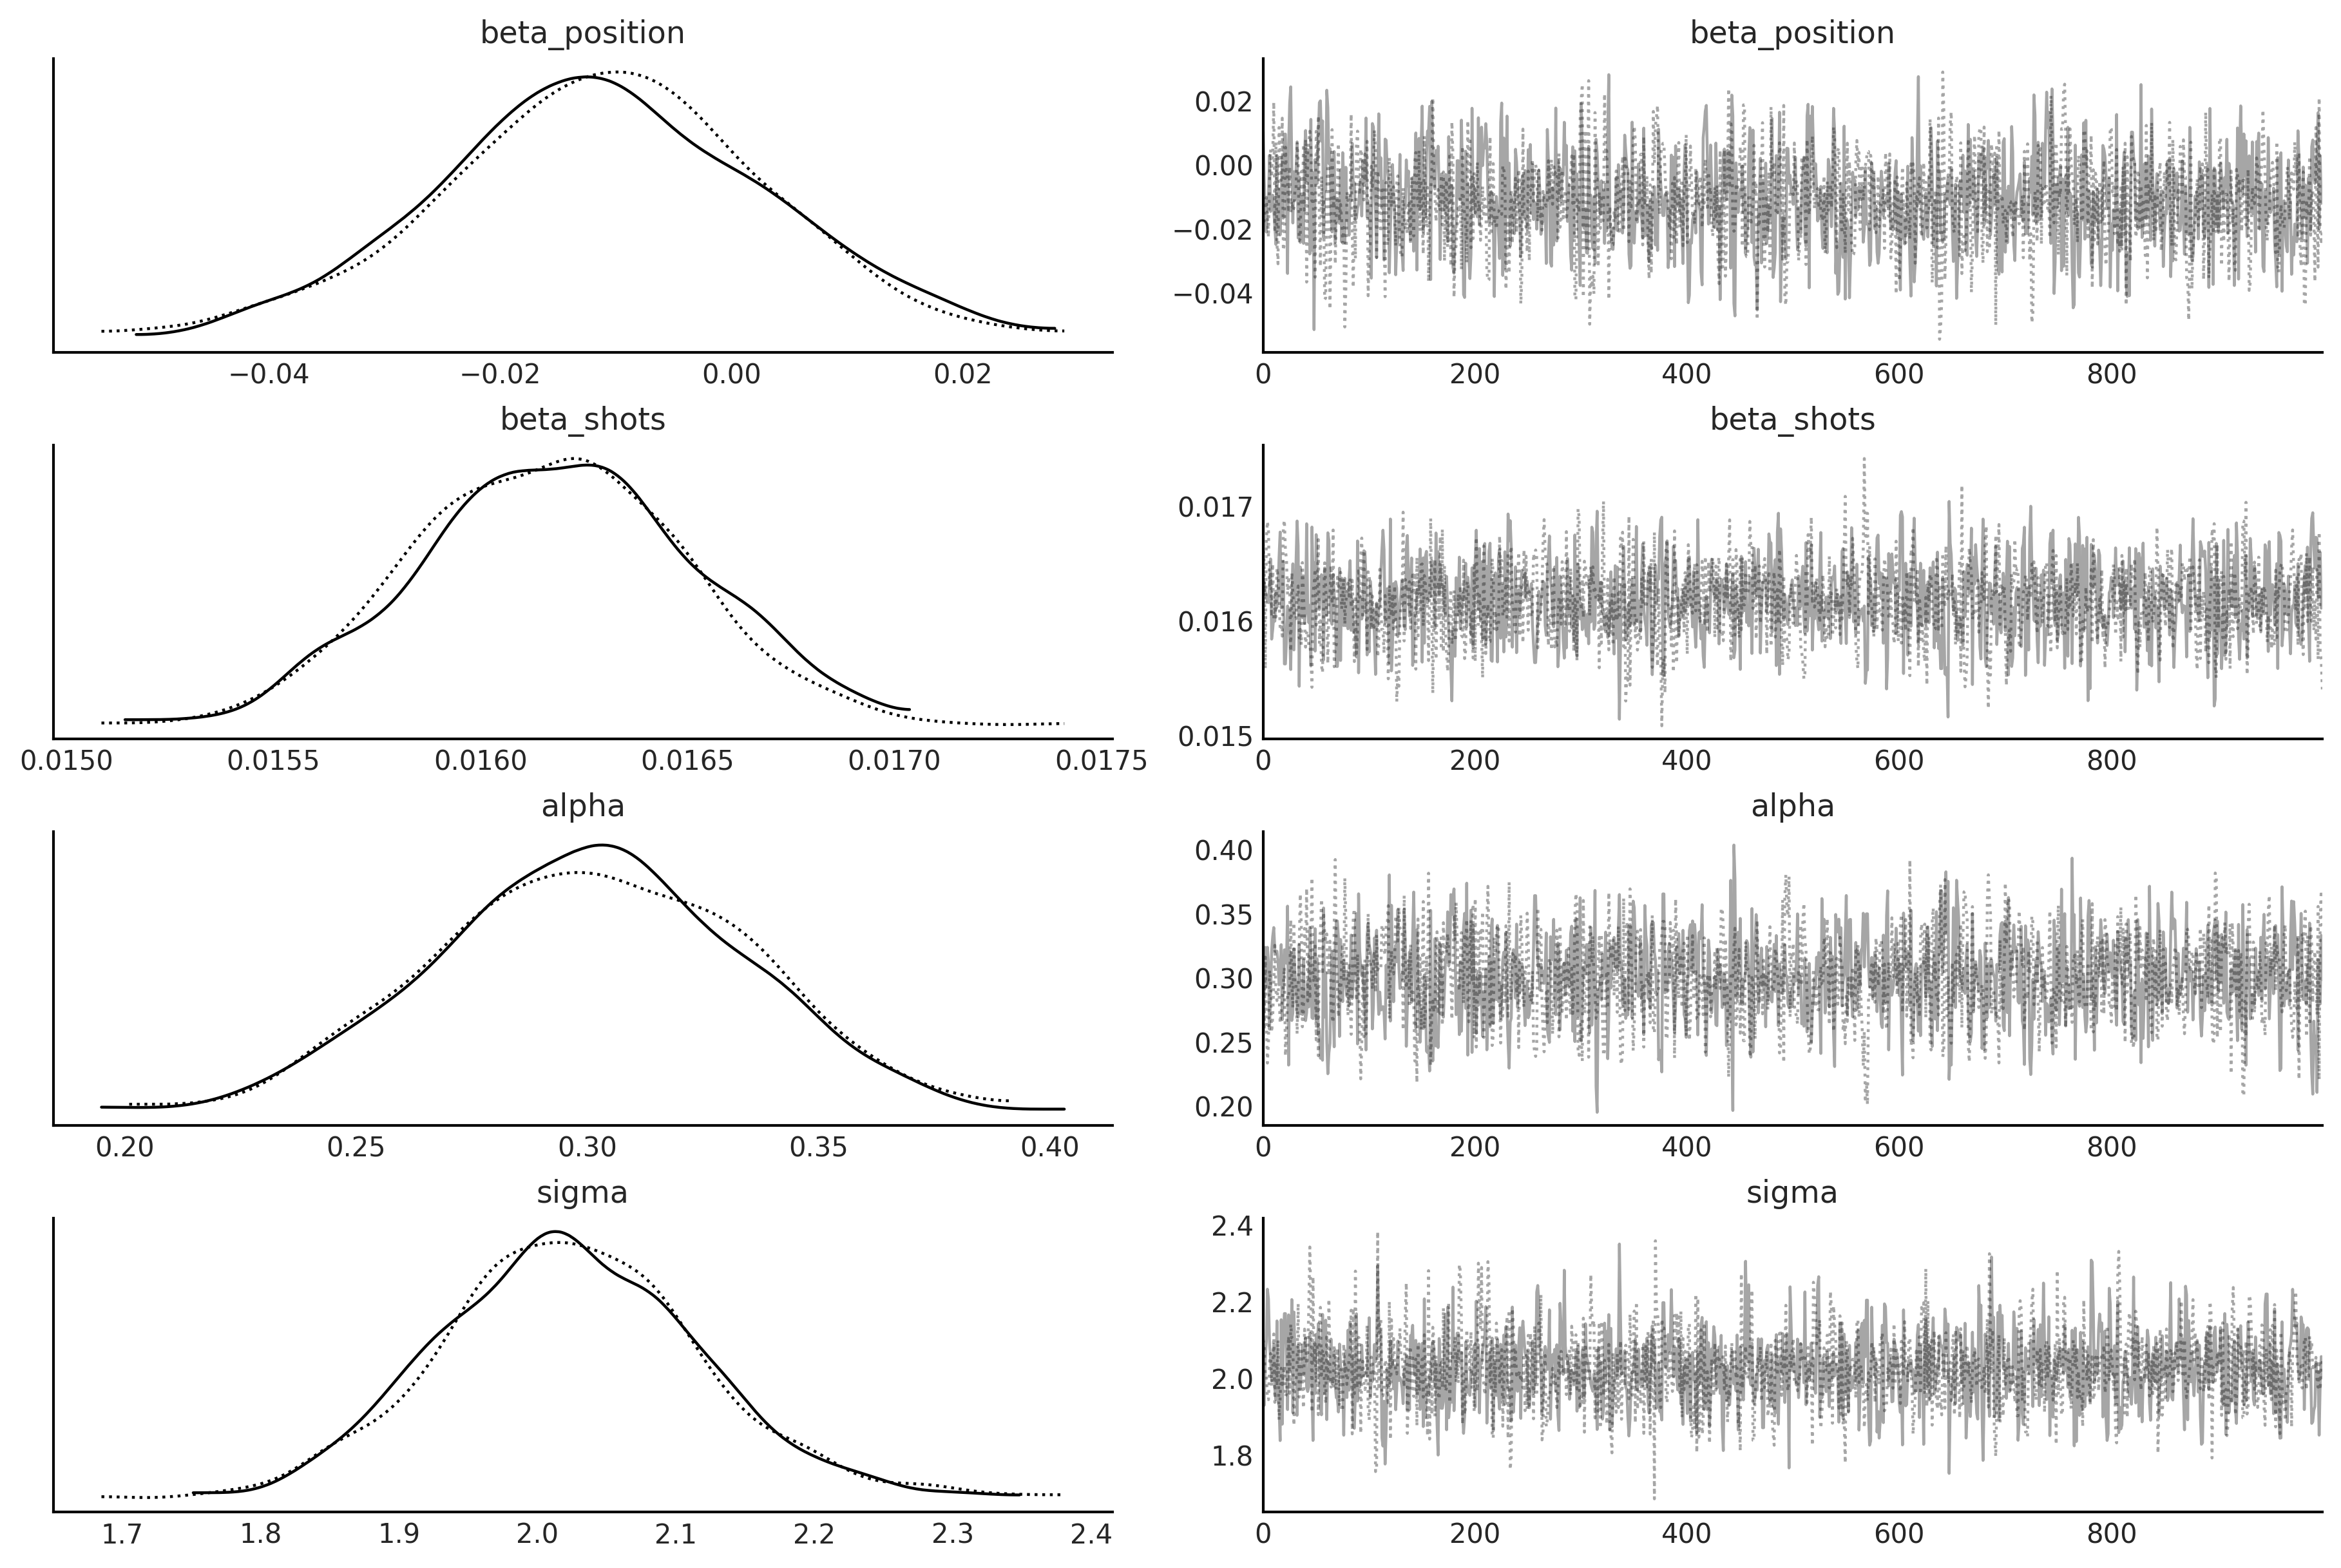

In [145]:
az.plot_trace(trace, var_names=["~mu"]);